# Hello RL Cart Pole

In [20]:
# Prerequisites
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
%matplotlib notebook

import gymnasium as gym
import pygame

import tensorflow as tf


### Create CartPole Environment

In [2]:
env = gym.make("CartPole-v1", render_mode="rgb_array")

Show available environments

In [3]:
envs = gym.envs.registry
for key in envs.keys():
    print(key)

CartPole-v0
CartPole-v1
MountainCar-v0
MountainCarContinuous-v0
Pendulum-v1
Acrobot-v1
phys2d/CartPole-v0
phys2d/CartPole-v1
phys2d/Pendulum-v0
LunarLander-v3
LunarLanderContinuous-v3
BipedalWalker-v3
BipedalWalkerHardcore-v3
CarRacing-v3
Blackjack-v1
FrozenLake-v1
FrozenLake8x8-v1
CliffWalking-v0
Taxi-v3
tabular/Blackjack-v0
tabular/CliffWalking-v0
Reacher-v2
Reacher-v4
Reacher-v5
Pusher-v2
Pusher-v4
Pusher-v5
InvertedPendulum-v2
InvertedPendulum-v4
InvertedPendulum-v5
InvertedDoublePendulum-v2
InvertedDoublePendulum-v4
InvertedDoublePendulum-v5
HalfCheetah-v2
HalfCheetah-v3
HalfCheetah-v4
HalfCheetah-v5
Hopper-v2
Hopper-v3
Hopper-v4
Hopper-v5
Swimmer-v2
Swimmer-v3
Swimmer-v4
Swimmer-v5
Walker2d-v2
Walker2d-v3
Walker2d-v4
Walker2d-v5
Ant-v2
Ant-v3
Ant-v4
Ant-v5
Humanoid-v2
Humanoid-v3
Humanoid-v4
Humanoid-v5
HumanoidStandup-v2
HumanoidStandup-v4
HumanoidStandup-v5
GymV21Environment-v0
GymV26Environment-v0


Show details for cartpole-v1 environment

In [4]:
print(envs["CartPole-v1"])

EnvSpec(id='CartPole-v1', entry_point='gymnasium.envs.classic_control.cartpole:CartPoleEnv', reward_threshold=475.0, nondeterministic=False, max_episode_steps=500, order_enforce=True, disable_env_checker=False, kwargs={}, namespace=None, name='CartPole', version=1, additional_wrappers=(), vector_entry_point='gymnasium.envs.classic_control.cartpole:CartPoleVectorEnv')


### Reset CartPole envinronment

In [5]:
obs, info = env.reset(seed=42)
print("info: ", info)
print("obs: ", obs)

info:  {}
obs:  [ 0.0273956  -0.00611216  0.03585979  0.0197368 ]


### Render image of the environment

Env image shape:  (400, 600, 3)


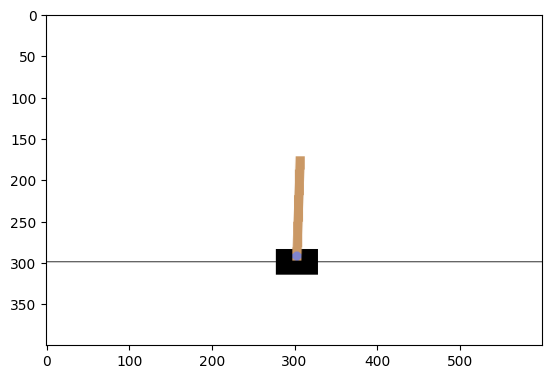

In [6]:
img = env.render()
print("Env image shape: ", img.shape)
plt.imshow(img)

### Check Action Space

In [7]:
print(env.action_space)

Discrete(2)


Two possible actions: accelerate to the left (0) or to the right (1).

In [8]:
action = 1  # accelerate right
obs, reward, done, truncated, info = env.step(action)
print("obs = ", obs)
print("reward = ", reward)
print("done = ", done)
print("truncated = ", truncated)
print("info = ", info)

obs =  [ 0.02727336  0.18847767  0.03625453 -0.26141977]
reward =  1.0
done =  False
truncated =  False
info =  {}


- obs[0] is position 
- obs[1] > 0, cart now moving toward the right 
- obs[2] > 0, the pole is still tilted toward the right 
- obs[3] < 0, angular velocity is now negative, likely tilted toward the left after the next step.

Env image shape:  (400, 600, 3)


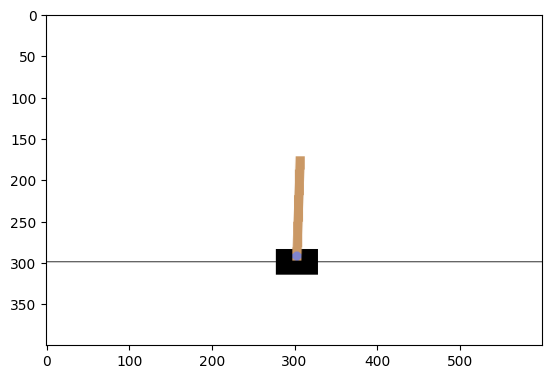

In [9]:
img = env.render()
print("Env image shape: ", img.shape)
plt.imshow(img)

### Simple Policy

In [10]:
def basic_policy(obs):
    angle = obs[2]
    return 0 if angle < 0 else 1

totals = []
for episode in range(500):
    episode_rewards = 0
    obs, info = env.reset(seed=episode)
    for step in range(200):
        action = basic_policy(obs)
        obs, reward, done, truncated, info = env.step(action)
        episode_rewards += reward
        if done or truncated:
            break

    totals.append(episode_rewards)

In [11]:
np.mean(totals), np.std(totals), min(totals), max(totals)

(np.float64(41.698), np.float64(8.389445512070509), 24.0, 63.0)

Pole stayed up for 63 steps only :-( 

### Visualize one Episode

In [ ]:
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

def show_one_episode(policy, n_max_steps=200, seed=42):
    frames = []
    env = gym.make("CartPole-v1", render_mode="rgb_array")
    np.random.seed(seed)
    obs, info = env.reset(seed=seed)
    for step in range(n_max_steps):
        frames.append(env.render())
        action = policy(obs)
        obs, reward, done, truncated, info = env.step(action)
        if done or truncated:
            break
    env.close()
    return plot_animation(frames)

show_one_episode(basic_policy)

### Create a Neural Network Policy

Create Policy Gradients

In [22]:
def play_one_step(env, obs, model, loss_fn):
    with tf.GradientTape() as tape:
        left_proba = model(obs[np.newaxis])
        action = (tf.random.uniform([1, 1]) > left_proba)
        y_target = tf.constant([[1.]]) - tf.cast(action, tf.float32)
        loss = tf.reduce_mean(loss_fn(y_target, left_proba))

    grads = tape.gradient(loss, model.trainable_variables)
    obs, reward, done, truncated, info = env.step(int(action))
    return obs, reward, done, truncated, grads

In [23]:
def play_multiple_episodes(env, n_episodes, n_max_steps, model, loss_fn):
    all_rewards = []
    all_grads = []
    for episode in range(n_episodes):
        current_rewards = []
        current_grads = []
        obs, info = env.reset()
        for step in range(n_max_steps):
            obs, reward, done, truncated, grads = play_one_step(
                env, obs, model, loss_fn)
            current_rewards.append(reward)
            current_grads.append(grads)
            if done or truncated:
                break

        all_rewards.append(current_rewards)
        all_grads.append(current_grads)

    return all_rewards, all_grads

In [24]:
def discount_rewards(rewards, discount_factor):
    discounted = np.array(rewards)
    for step in range(len(rewards) - 2, -1, -1):
        discounted[step] += discounted[step + 1] * discount_factor
    return discounted

def discount_and_normalize_rewards(all_rewards, discount_factor):
    all_discounted_rewards = [discount_rewards(rewards, discount_factor)
                              for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean) / reward_std
            for discounted_rewards in all_discounted_rewards]

Hyperparameters

In [25]:
n_iterations = 150
n_episodes_per_update = 10
n_max_steps = 200
discount_factor = 0.95

### Define ANN

In [26]:
tf.random.set_seed(42)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(5, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid"),
])

obs, info = env.reset(seed=42)

optimizer = tf.keras.optimizers.Nadam(learning_rate=0.01)
loss_fn = tf.keras.losses.binary_crossentropy

### Training Loop

In [27]:
for iteration in range(n_iterations):
    all_rewards, all_grads = play_multiple_episodes(
        env, n_episodes_per_update, n_max_steps, model, loss_fn)

    # extra code – displays some debug info during training
    total_rewards = sum(map(sum, all_rewards))
    print(f"\rIteration: {iteration + 1}/{n_iterations},"
          f" mean rewards: {total_rewards / n_episodes_per_update:.1f}", end="")

    all_final_rewards = discount_and_normalize_rewards(all_rewards,
                                                       discount_factor)
    all_mean_grads = []
    for var_index in range(len(model.trainable_variables)):
        mean_grads = tf.reduce_mean(
            [final_reward * all_grads[episode_index][step][var_index]
             for episode_index, final_rewards in enumerate(all_final_rewards)
                 for step, final_reward in enumerate(final_rewards)], axis=0)
        all_mean_grads.append(mean_grads)

    optimizer.apply_gradients(zip(all_mean_grads, model.trainable_variables))

Iteration: 150/150, mean rewards: 192.9